In [1]:
import numpy as np
import pandas as pd
from sklearn import ensemble
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
import os
import math as m
import seaborn as sns
import collections

from sklearn.preprocessing import StandardScaler

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
numThreads = 88

# Set number of threads for inter-operator parallelism,
# start with a single thread
numInterOpThreads = 1

# The total number of threads must be an integer multiple
# of numInterOpThreads to make sure that all cores are used
assert numThreads % numInterOpThreads == 0

# Compute the number of intra-operator threads; the number
# of OpenMP threads for low-level libraries must be set to
# the same value for optimal performance
numIntraOpThreads = numThreads // numInterOpThreads
os.environ['OMP_NUM_THREADS'] = str(numIntraOpThreads)

# Import TensorFlow after setting OMP_NUM_THREADS to make sure
# that low-level libraries are initialised correctly
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

# Configure TensorFlow
tf.config.threading.set_inter_op_parallelism_threads(numInterOpThreads)
tf.config.threading.set_intra_op_parallelism_threads(numIntraOpThreads)

seed = 42

In [2]:
def fileparser(path, dlist, frac=0.5, sample=0, L=2):
    """ The fileparser to read the events from a csv
        argument:
            path: the path to the file
            dlist: the list of variables to be excluded
            frac: the fraction of sample that will be the test sample when sample is set to 0
            sample: the number of events that will be the train sample.
            L: Luminosity scaling
        returns:
            df_train: the training dataframe
            df_test: the testing dataframe
            weight: the weight (related to crosssection)
    """
    df = pd.read_csv(path)
    df.drop(columns=dlist, inplace=True)    
    n = len(df)
    weight = int(round(np.abs(df['weight'].sum()) * 3. * 1e6 * L)) ## The abs(mean()) is taken to make the weight of ybyt +ve
    df['weight'] = df['weight']/np.abs(df['weight'])
    if sample != 0:
        df_train = df.sample(n=sample, random_state=seed)
        df_test = df.drop(df_train.index)
    else :
        df_test = df.sample(frac=frac, random_state=seed)
        df_train = df.drop(df_test.index)
    return df_train, df_test, weight


def get_mclass(i, df_array, weight_array, ps_exp_class, model, seed=seed):
    """ This function is used to create the confusion matrix
        arguments:
            i: integer corresponding to the class number
            df_array: the array of the dataframes of the different classes
            weight_array: the array of the weights for the different classes
            ps_exp_class: the collection of the pseudo experiment events
            seed: the seed for the random number generator
        returns:
            nevents: the number of events
            sif: the significance
    """
    mclass = []
    for j in range(nchannels):
        predict = model.predict(df_array[j].iloc[:,:-2].values)
        mclass.append(collections.Counter(np.array([np.argmax(predict[i]) for i in range(len(predict))]))[i]/len(df_array[j])*weight_array[j]/weight_array[i])

    sig = np.sqrt(ps_exp_class[i])*mclass[i]/np.sum(mclass)
    nevents = np.round(ps_exp_class[i]/np.sum(mclass)*np.array(mclass)).astype(int)
    print('sig: {:2.2f}, yb2 events: {}, ybyt events: {}, yt2 events: {}, zh events: {}, bbxaa events: {}'.format(sig, nevents[4], nevents[3], nevents[2], nevents[1], nevents[0]))
    return nevents, sig 


class PrintDots(Callback):
    """ Print dots to monitor the progress of the fit
    """
    def on_epoch_end(self, epoch, logs):
        logs = logs or {}
        value = logs.get('val_loss')
        if epoch % 50 == 0:
            print(' epochs = ', epoch, ' val_loss = ', value)
        print('*', end='')
                
class TerminateOnBaseline(Callback):
    """ Callback that terminates training when monitored value reaches a specified baseline
    """
    def __init__(self, monitor='val_loss', patience=200):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = np.Inf
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf
        self.best_weights = None
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        value = logs.get(self.monitor)
        if epoch == 0:
            self.baseline = value/100.
        if np.less(value, self.best):
            self.best = value
            self.wait = 0
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch
        else:
            self.wait += 1
        if value is not None:
            if value <= self.baseline and self.wait >= self.patience:
                self.stopped_epoch = epoch
                print('\nepoch %d: Reached baseline, terminating training and lost patience' % epoch)
                self.model.stop_training = True
                print('Restoring model weights from the end of the best epoch: ' + str(self.best_epoch))
                self.model.set_weights(self.best_weights)
            elif self.wait >= self.patience:
                self.baseline *= 2.5
                self.wait = self.patience/2
                
def plot_history(history):
    """ Plots to track the history of the metrics
    """
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('accuracy [y]')
    plt.plot(hist['epoch'], hist['accuracy'], label='train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='val accuracy')
#     plt.ylim([0.5, 0.7])
    plt.legend()
    plt.show()

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'], label='train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val loss')
#     plt.ylim([0.8, 1])
    plt.legend()
    plt.show()
    
def build_model(df, channels, width, layers, l1=0., l2=0.):
    """ Build the model, define the optimizer and compile the model
    """
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(width, activation='relu', input_shape=[len(df.keys())-1]))
    for i in range (1, layers):
        if l1 == 0. and l2 == 0.: 
            model.add(tf.keras.layers.Dense(width, activation='relu'))
        else:
            model.add(tf.keras.layers.Dense(width, activation='relu', 
                      kernel_regularizer=tf.keras.regularizers.L1(0.01), 
                      activity_regularizer=tf.keras.regularizers.L2(0.01)))
    model.add(tf.keras.layers.Dense(channels, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## 14 TeV Analysis

### Load the data

In [3]:
dlist = ['dphibb', 'etaaa', 'ptb2', 'drbamin', 'met', 'etaa2', 'etab1', 'etaa1', 'nbjet', 'etab2']
names = [r'$n_{jet}$', r'$p_T^{b_1}$', r'$p_T^{\gamma_1}$', r'$p_T^{\gamma_2}$', r'$p_T^{\gamma\gamma}$', r'$m_{bb}$', r'$m_{\gamma\gamma}$', r'$m_{b_1h}$', r'$m_{bbh}$',
           r'$H_T$', r'$\delta R_{b\gamma_1}$', r'$\delta\phi_{b\gamma_1}$']

# 14 TeV
df_yb2, df_yb2_test, weight_yb2 = fileparser("../simulations/HL-LHC/yb2.csv", dlist, sample=20000)
df_ybyt, df_ybyt_test, weight_ybyt = fileparser("../simulations/HL-LHC/ybyt.csv", dlist, sample=20000)
df_yt2, df_yt2_test, weight_yt2 = fileparser("../simulations/HL-LHC/yt2.csv", dlist, sample=20000)
df_zh, df_zh_test, weight_zh = fileparser("../simulations/HL-LHC/zh.csv", dlist, sample=40000)
df_bbxaa, df_bbxaa_test, weight_bbxaa = fileparser("../simulations/HL-LHC/bbxaa.csv", dlist, sample=100000)

print("No. of yb2 events: train = {}, test = {}".format(df_yb2.shape[0],df_yb2_test.shape[0]))
print("No. of ybyt events: train = {}, test = {}".format(df_ybyt.shape[0],df_ybyt_test.shape[0]))
print("No. of yt2 events: train = {}, test = {}".format(df_yt2.shape[0],df_yt2_test.shape[0]))
print("No. of zh events: train = {}, test = {}".format(df_zh.shape[0],df_zh_test.shape[0]))
print("No. of bbxaa events: train = {}, test = {}".format(df_bbxaa.shape[0],df_bbxaa_test.shape[0]))

No. of yb2 events: train = 20000, test = 26740
No. of ybyt events: train = 20000, test = 18341
No. of yt2 events: train = 20000, test = 81774
No. of zh events: train = 40000, test = 139021
No. of bbxaa events: train = 100000, test = 37488


In [4]:
channels = [df_yb2, df_zh]
nchannels = len(channels)
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

model = build_model(df_yb2.iloc[:,:-1], nchannels, 16, 2)
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                208       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 514
Trainable params: 514
Non-trainable params: 0
_________________________________________________________________


 epochs =  0  val_loss =  1.7194292545318604
************************************************** epochs =  50  val_loss =  0.44613444805145264
************************************************** epochs =  100  val_loss =  0.4407585859298706
************************************************** epochs =  150  val_loss =  0.4378567039966583
************************************************** epochs =  200  val_loss =  0.43597492575645447
************************************************** epochs =  250  val_loss =  0.4309746026992798
************************************************** epochs =  300  val_loss =  0.42749693989753723
************************************************** epochs =  350  val_loss =  0.42827174067497253
************************************************** epochs =  400  val_loss =  0.4270702600479126
************************************************** epochs =  450  val_loss =  0.42536845803260803
************************************************** epochs =  500  val_loss =  

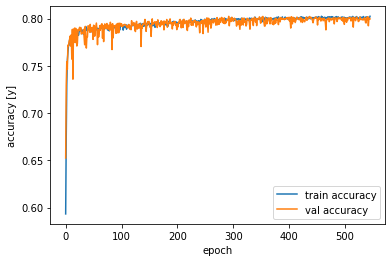

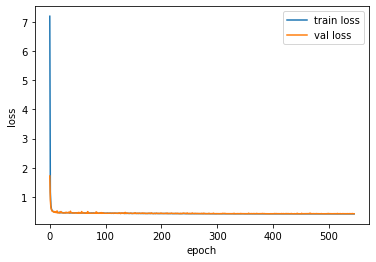

Testing set accuracy for yb2: 58.50%
Testing set accuracy for zh: 90.71%


In [5]:
# learning_rate = 0.003
EPOCHS = 200000
patience = 50
df_train_set = df_train.iloc[:,:-1]
df_train_labels = df_train_set.pop('class')
df_train_labels[df_train_labels == 4] = 0

df_yb2_test_cp = df_yb2_test.iloc[:,:-1]
df_yb2_test_cp['class'] = 0

df_zh_test_cp = df_zh_test.drop(df_zh_test[df_zh_test.iloc[:,-1]<0].index)
df_zh_test_cp = df_zh_test_cp.iloc[:,:-1]



""" Extract the history of the fit
"""
history = model.fit(
    df_train_set, df_train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size=320,
    callbacks=[TerminateOnBaseline(monitor='val_loss', patience=patience), PrintDots()])

""" Extract the history and make some plots
"""
print("\n", "Epochs = ", history.epoch[-1])
plot_history(history)

loss, accuracy = model.evaluate(df_yb2_test_cp.iloc[:,:-1], df_yb2_test_cp.iloc[:,-1], verbose=0)
print("Testing set accuracy for yb2: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_zh_test_cp.iloc[:,:-1], df_zh_test_cp.iloc[:,-1], verbose=0)
print("Testing set accuracy for zh: {:4.2f}%".format(accuracy*100))

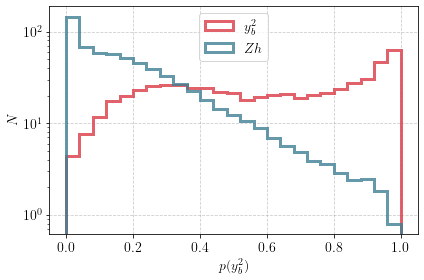

In [6]:
disc = 0
enc = 100
test_predictions_yb2 = model.predict(df_yb2_test_cp.sample(n=round(weight_yb2*1.5*enc), replace=True).reset_index(drop=True).iloc[:,:-1])[:,disc]
test_predictions_zh = model.predict(df_zh_test_cp.sample(n=round(weight_zh*1.3*enc), replace=True).reset_index(drop=True).iloc[:,:-1])[:,disc]


plt.figure(figsize=(6,4))
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
sns.distplot(test_predictions_yb2, kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(test_predictions_yb2)}, label=r'$y_b^2$', color='#da3b46')
sns.distplot(test_predictions_zh, kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(test_predictions_zh)}, label=r'$Zh$', color='#3f7f93')
plt.legend(loc='upper center', fontsize=14)
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel(r'$p(y_b^2)$', fontsize=14)
plt.ylabel(r'$N$', fontsize=14)
plt.yscale('log')
plt.tight_layout()
plt.savefig('../plots/zh-yb2-DNN-dist.pdf', dpi=300)

In [7]:
channels = [df_bbxaa, df_zh, df_yt2, df_ybyt, df_yb2]
nchannels = len(channels)
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

# Special treatment for ybyt
df_tmp = pd.read_csv("../simulations/HL-LHC/ybyt.csv")
ybyt_ratio = df_tmp[df_tmp['weight']<0].shape[0]/df_tmp[df_tmp['weight']>0].shape[0]

model = build_model(df_yb2.iloc[:,:-1], nchannels, 64, 12)
model.summary() 
# 64, 12

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                832       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

In [ ]:
# learning_rate = 0.003
EPOCHS = 200000
patience = 50
df_train_set = df_train.iloc[:,:-1]
df_train_labels = df_train_set.pop('class')

df_zh_test = df_zh_test.drop(df_zh_test[df_zh_test.iloc[:,-1]<0].index)
df_yt2_test = df_yt2_test.drop(df_yt2_test[df_yt2_test.iloc[:,-1]<0].index)

""" Extract the history of the fit
"""
history = model.fit(
    df_train_set, df_train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size=320,
    callbacks=[TerminateOnBaseline(monitor='val_loss', patience=patience), PrintDots()])

""" Extract the history and make some plots
"""
print("\n", "Epochs = ", history.epoch[-1])
plot_history(history)

loss, accuracy = model.evaluate(df_yb2_test.iloc[:,:-2], df_yb2_test['class'], verbose=0)
print("Testing set accuracy for yb2: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_ybyt_test.iloc[:,:-2], df_ybyt_test['class'], verbose=0)
print("Testing set accuracy for ybyt: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_yt2_test.iloc[:,:-2], df_yt2_test['class'], verbose=0)
print("Testing set accuracy for yt2: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_zh_test.iloc[:,:-2], df_zh_test['class'], verbose=0)
print("Testing set accuracy for zh: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_bbxaa_test.iloc[:,:-2], df_bbxaa_test['class'], verbose=0)
print("Testing set accuracy for bbxaa: {:4.2f}%".format(accuracy*100))

 epochs =  0  val_loss =  1.1607283353805542
**

In [ ]:
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.3, weight_yt2*2.5, weight_ybyt*1.9, weight_yb2*1.5]

predict = model.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values)

ps_exp_class = collections.Counter(np.array([np.argmax(predict[i]) for i in range(len(predict))]))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class, model)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class, model)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class, model)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class, model)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class, model)
confusion = np.column_stack((nevents_yb2, nevents_ybyt, nevents_yt2, nevents_zh, nevents_bbxaa))

In [ ]:
df_ybyt_test_pos = df_ybyt_test[df_ybyt_test['weight']==1]
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test_pos, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.3, weight_yt2*2.5, (1./(ybyt_ratio-1.))*weight_ybyt*1.9, weight_yb2*1.5]

predict = model.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values)

ps_exp_class = collections.Counter(np.array([np.argmax(predict[i]) for i in range(len(predict))]))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class, model)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class, model)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class, model)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class, model)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class, model)
confusion_pos = np.column_stack((nevents_yb2, nevents_ybyt, nevents_yt2, nevents_zh, nevents_bbxaa))

In [ ]:
df_ybyt_test_neg = df_ybyt_test[df_ybyt_test['weight']==-1]
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test_neg, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.3, weight_yt2*2.5, (ybyt_ratio/(ybyt_ratio-1.))*weight_ybyt*1.9, weight_yb2*1.5]

predict = model.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values)

ps_exp_class = collections.Counter(np.array([np.argmax(predict[i]) for i in range(len(predict))]))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class, model)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class, model)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class, model)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class, model)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class, model)
confusion_neg = np.column_stack((nevents_yb2, nevents_ybyt, nevents_yt2, nevents_zh, nevents_bbxaa))

In [ ]:
confusion_tot = np.round(np.array([confusion_pos[4]*0.5, confusion_pos[3], confusion_pos[2]*0.5, confusion_pos[1]*0.5, confusion_pos[0]*0.5])
        +np.array([confusion_neg[4]*0.5, -confusion_neg[3], confusion_neg[2]*0.5, confusion_neg[1]*0.5, confusion_neg[0]*0.5])).astype(int)
confusion_tot_tmp = confusion_tot
event_total = np.array([[np.sum(confusion_tot[i])] for i in range(confusion_tot.shape[0])])
significance = np.array([np.abs(confusion_tot[i,i])/np.sqrt(np.sum(confusion_tot[:,i])) for i in range(confusion_tot.shape[0])])
significance = np.append(significance, 0)
confusion_tab1 = np.append(confusion_tot_tmp, event_total, axis=1)
confusion_tab2 = np.vstack((confusion_tab1, significance))
    
df_conf = pd.DataFrame(confusion_tab2, [r'$y_b^2$', r'$y_by_t$', r'$y_t^2$', r'$Zh$', r'$bb\gamma\gamma$', r'$\sigma$'])
df_conf.columns = [r'$y_b^2$', r'$y_by_t$', r'$y_t^2$', r'$Zh$', r'$bb\gamma\gamma$', 'total']
print(df_conf.to_latex(escape=False))